In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom as dcm
import os
import glob

%matplotlib inline

In [ ]:
import pandas as pd
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [ ]:
INPUT_FOLDER = '../imagedata/Esophagus_DICOM_211Pt/133673/'
scans = os.listdir(INPUT_FOLDER)
scans.sort()

In [ ]:
lstFilesDCM = []
def load_scan(path):
    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ".dcm" in filename.lower():
                lstFilesDCM.append(os.path.join(dirName,filename))
    return lstFilesDCM

first_patient = load_scan(INPUT_FOLDER)
for i,j in enumerate(first_patient):
    if j[42:44] == 'RS':
        rtstr = first_patient.pop(i)
len(first_patient)

In [ ]:
rtstrdcm = dcm.read_file(rtstr)

In [ ]:
RefIDs = dcm.read_file(first_patient[4])
ConstPixelDims = (int(RefIDs.Rows),int(RefIDs.Columns),len(first_patient))
ConstPixelSpacing = (float(RefIDs.PixelSpacing[0]),float(RefIDs.PixelSpacing[1]),float(RefIDs.SliceThickness))

In [ ]:
RefIDs.InstanceNumber

In [ ]:
ConstPixelSpacing, ConstPixelDims

In [ ]:
x = np.arange(0.0,(ConstPixelDims[0]+1)*ConstPixelSpacing[0],ConstPixelSpacing[0])
y = np.arange(0.0,(ConstPixelDims[1]+1)*ConstPixelSpacing[1],ConstPixelSpacing[1])
z = np.arange(0.0,(ConstPixelDims[2]+1)*ConstPixelSpacing[2],ConstPixelSpacing[2])

In [ ]:
ArrayDicom = np.zeros(ConstPixelDims,dtype=RefIDs.pixel_array.dtype)
for filenameDCM in first_patient:
    ds = dcm.read_file(filenameDCM)
    ArrayDicom[:,:,ds.InstanceNumber-1] = ds.pixel_array

In [ ]:
#ArrayDicom

In [ ]:
plt.figure(dpi=1600)
plt.axes().set_aspect('equal','datalim')
plt.set_cmap(plt.gray())
plt.pcolormesh(x,y,np.flipud(ArrayDicom[:,:,105]))

In [ ]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

In [ ]:
import pydicom
import seaborn as sns
matplotlib.rcParams['image.cmap'] = 'bone'
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [ ]:
#get dicom files
csource = '../imagedata/Esophagus_DICOM_211Pt/127279/'
citems = get_dicom_files(csource)
#now lets read a file:
patient2 = dcm.read_file(citems[10])
patient2.show()

In [ ]:
patient2

In [ ]:
#patient2

In [ ]:
rtstrdcm

In [ ]:
RefIDs = dcm.read_file(first_patient[11])
RefIDs

In [ ]:
pat1 = citems[10].dcmread()

In [ ]:
plt.hist(pat1.pixels.flatten().numpy())

In [ ]:
pat1.show()

In [ ]:
plt.hist(pat1.scaled_px.flatten().numpy());

In [ ]:
img_raw = pat1.pixels.numpy()
img_scaled = pat1.scaled_px.numpy()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(24,16))

axs[0].imshow(img_raw,cmap='gray')
axs[1].imshow(img_scaled,cmap='gray')
  
fig.suptitle('Raw image versus Scaled image')
#plt.figure(figsize=(12,4))
plt.show()

In [ ]:
img_raw.min(), img_scaled.min()

In [ ]:
img_raw_norm = (img_raw-img_raw.min())/(img_raw.max()-img_raw.min())
img_scaled_norm = (img_scaled-img_scaled.min())/(img_scaled.max()-img_scaled.min())

In [ ]:
fig, axs = plt.subplots(2, 2,figsize=(24,16))

axs[0,0].imshow(img_raw,cmap='gray')
axs[0,1].imshow(img_scaled,cmap='gray')
axs[1,0].imshow(img_raw_norm,cmap='gray')
axs[1,1].imshow(img_scaled_norm,cmap='gray') 

fig.subplots_adjust(wspace=0.05,hspace=0.1)
#fig.suptitle('Raw image versus Scaled image')
fig.tight_layout()
plt.show()

# Kaggle Preprocessing Tutorial

> [Refrence](https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial)

In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '../imagedata/test_dicom/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [2]:
patients.pop(0)

'.DS_Store'

In [3]:
# Load the scans in given folder path
def load_scan(path):
    slices = []
    for s in os.listdir(INPUT_FOLDER + patients[0]):
        if s != '.DS_Store':
            slices.append(pydicom.read_file(INPUT_FOLDER+ patients[0] + '/' + s,force=True))
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [4]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [335]:
patients[0]

'133673'

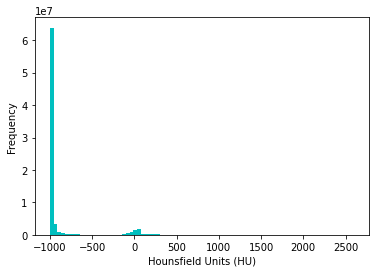

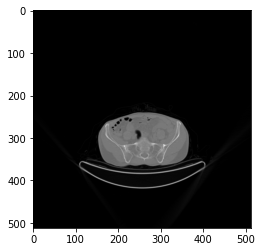

In [5]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [337]:
first_patient_pixels.min()

-1000

In [6]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + [scan[0].PixelSpacing[0]] +
                       [scan[0].PixelSpacing[1]], dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [7]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (290, 512, 512)
Shape after resampling	 (870, 700, 700)


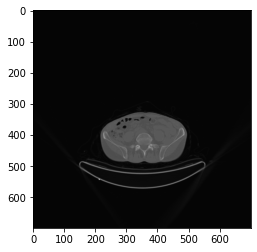

In [8]:
plt.imshow(pix_resampled[268], cmap=plt.cm.gray)

In [9]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces,_,_ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [10]:
#plot_3d(pix_resampled, 500)

# Exploring RT Structure File

In [11]:
strfiles = '../imagedata/RTstrFiles/RS.133673.dcm'

In [12]:
strfile = pydicom.dcmread(strfiles)

In [13]:
strfile.dir('contour')

['ROIContourSequence']

In [14]:
contours = strfile.ROIContourSequence

In [15]:
contours[0]

(3006, 002a) ROI Display Color                   IS: [255, 0, 0]
(3006, 0040)  Contour Sequence  30 item(s) ---- 
   (3006, 0016)  Contour Image Sequence  1 item(s) ---- 
      (0008, 1150) Referenced SOP Class UID            UI: CT Image Storage
      (0008, 1155) Referenced SOP Instance UID         UI: 1.3.12.2.1107.5.1.4.1018.30000011072103541962500002531
      ---------
   (3006, 0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
   (3006, 0046) Number of Contour Points            IS: "56"
   (3006, 0050) Contour Data                        DS: Array of 168 elements
   ---------
   (3006, 0016)  Contour Image Sequence  1 item(s) ---- 
      (0008, 1150) Referenced SOP Class UID            UI: CT Image Storage
      (0008, 1155) Referenced SOP Instance UID         UI: 1.3.12.2.1107.5.1.4.1018.30000011072103541962500002530
      ---------
   (3006, 0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
   (3006, 0046) Number of Contour Points            IS: "64"
   

In [16]:
contours[0].ContourSequence[0].ContourImageSequence[0].ReferencedSOPInstanceUID

'1.3.12.2.1107.5.1.4.1018.30000011072103541962500002531'

In [23]:
cdata01 = contours[0].ContourSequence[0].ContourData

In [18]:
first_patient[0].SOPInstanceUID

'1.3.12.2.1107.5.1.4.1018.30000011072103541962500002688'

In [19]:
i=0
for scan in first_patient:
    if scan.SOPInstanceUID == contours[0].ContourSequence[0].ContourImageSequence[0].ReferencedSOPInstanceUID:
        print(f'Scan No: {i} and Image Position is {scan.ImagePositionPatient}')
    i +=1

Scan No: 157 and Image Position is [-349.31640625, -522.31640625, -942]


In [20]:
first_patient[157].ImagePositionPatient

[-349.31640625, -522.31640625, -942]

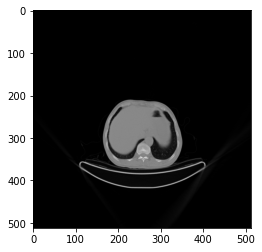

In [22]:
plt.imshow(first_patient[157].pixel_array,cmap=plt.cm.gray)

In [320]:
x = []
y = []
i = len(cdata01)
m=0
while m < i:
    x.append(float(cdata01[m]))
    m+=3
n=1
while n < i:
    y.append(float(cdata01[n]))
    n+=3
z = cdata01[2]

In [321]:
len(x), len(y)

(56, 56)

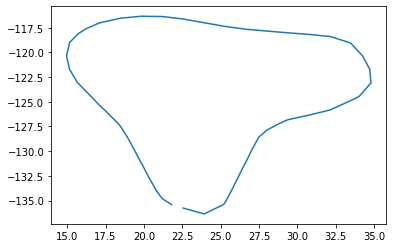

In [322]:
#plt.imshow(first_patient[157].pixel_array,cmap=plt.cm.gray,alpha=0.1)
plt.plot(x,y)

image position -349.31640625, -522.31640625

In [328]:
x_new = (np.array(x)+(-349.31640625))*-1
y_new = (np.array(y)+(-522.31640625))*-1

In [329]:
y_new = y_new - 360
x_new = x_new - 50

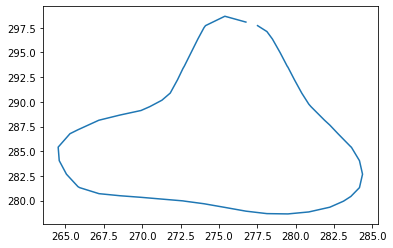

In [330]:
plt.plot(x_new,y_new)

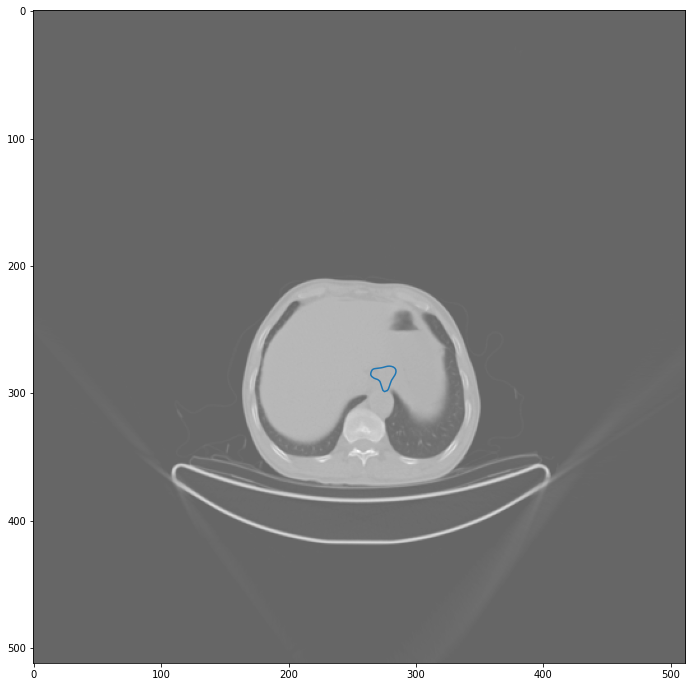

In [331]:
plt.figure(figsize=(24,12))
plt.imshow(first_patient[157].pixel_array,cmap=plt.cm.gray,alpha=0.6)
plt.plot(x_new,y_new)

In [255]:
contours[0].ContourSequence[0].ContourImageSequence[0].ReferencedSOPInstanceUID
cdata01 = contours[0].ContourSequence[0].ContourData

In [256]:
cdata = []
for i in range(len(contours[0].ContourSequence)):
    cdata.append(contours[0].ContourSequence[i].ContourData)

In [257]:
contour_list = []

In [295]:
k = 0
for data in cdata:
    x = []
    y = []
    i = len(data)
    m=0
    while m < i:
        x.append(float(data[m]))
        m+=3
    n=1
    while n < i:
        y.append(float(data[n]))
        n+=3
    z = [float(data[2])]
    tmplist = (x,y,z)
    contour_list.append(tmplist)
    k+=1

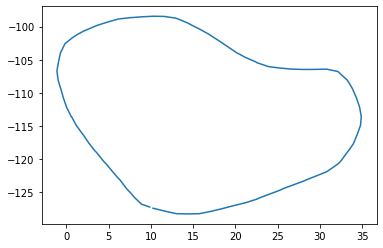

In [297]:
cno = 19
plt.plot(contour_list[cno][0],contour_list[cno][1])

In [299]:
first_patient[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 164
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.1.4.1018.30000011072103541962500002688
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.246.352.70.2.1.7
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0012) Instance Creation Date              DA: '20200203'
(0008, 0013) Instance Creation Time              TM: '164932.190000'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.1018.

In [334]:
len(pix_resampled)

870